In [1]:
# If external python files are updated
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, recall_score

import torch.nn.init as init
from torch.optim import lr_scheduler

import functions
from functions import Custom_DNN, EarlyStopper

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

Device used: cpu


In [2]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
train_size = 0.75                     # In percent
test_size = 1 - train_size           # In percent, calculated dynamically from train_size
batch_size = 16                      # Size of batches

**Data Import**

Custom Dataset Class

In [4]:
from torch.utils.data import Dataset
from torchvision.transforms import v2
from PIL import Image
import os

class CustomDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_folders = os.listdir(root_dir)
        self.class_to_idx = {class_folder: i for i, class_folder in enumerate(self.class_folders)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for class_folder in self.class_folders:
            class_path = os.path.join(self.root_dir, class_folder)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, self.class_to_idx[class_folder]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path)

        random_number = np.random.uniform(0, 1)

        if self.transform:
            image = self.apply_random_transform(image, random_number)

        return image, label
    
    def apply_random_transform(self, image, random_number):

        if random_number < 0.25:
            return transforms['noise_gaussian'](image)
        elif random_number < 0.5:
            return transforms['noise_salt_pepper'](image)
        else:
            return transforms['none'](image)
    

In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

# Convert to Tensor
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

train_size = 0.6
val_size = 0.2
test_size = 0.2

dataset = CustomDataset(root_dir='data', transform=transform)
train_dataset, test_dataset = train_test_split(dataset, train_size=train_size, test_size=test_size+val_size, random_state=seed)
test_dataset, val_dataset = train_test_split(test_dataset, train_size=test_size/(test_size+val_size), test_size=val_size/(test_size+val_size), random_state=seed)

print(f'Train size: {len(train_dataset)}'
        f'\nValidation size: {len(val_dataset)}'
        f'\nTest size: {len(test_dataset)}')

# Define DataLoader for training, validation and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data'

# Dynamic DNN creation

In [14]:
# Example usage of dense neural network

# First define criterion
# criterion = functions.FocalLoss()
criterion = nn.CrossEntropyLoss()

# Now define the metrics you want to monitor during training and save them in a dict (Important: All need to take y_pred, y_cls, y_true as input (This order!))
def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))
def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)
def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')
metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

# Define instance of model and initialize the weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)

dynamic_model = Custom_DNN(input_size=128**2, initial_nodes=128, output_size=4, n_layers=4, operation_and_factor= ('/', 4), dropout_rate=0.2, evaluation_metrics = metrics)
dynamic_model.apply(init_weights)

# Now define the loss (criterion), optimizer, lr_scheduler, 
early_stopper = EarlyStopper(dynamic_model, patience=3, min_delta=0)
optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Now use the training function to train the network
functions.train_network(dynamic_model, train_loader, criterion, optimizer, 20, scheduler, validation_loader, device, early_stopper)

Size last layer before output: 8
Device used for training: cpu
Epoch [1/20]  loss: 1.2712, acc: 0.5000, macro recall: 0.2500
Epoch [2/20]  loss: 1.2618, acc: 0.5000, macro recall: 0.2500
Epoch [3/20]  loss: 1.2359, acc: 0.5000, macro recall: 0.2500
Epoch [4/20]  loss: 1.2233, acc: 0.5000, macro recall: 0.2500
Epoch [5/20]  loss: 1.2219, acc: 0.5283, macro recall: 0.2749
Epoch [6/20]  loss: 1.2298, acc: 0.5658, macro recall: 0.3243
Epoch [7/20]  loss: 1.2143, acc: 0.5633, macro recall: 0.3199
Epoch [8/20]  loss: 1.2020, acc: 0.5742, macro recall: 0.3283
Epoch [9/20]  loss: 1.1907, acc: 0.5733, macro recall: 0.3343
Epoch [10/20]  loss: 1.1906, acc: 0.5758, macro recall: 0.3290
Epoch [11/20]  loss: 1.1796, acc: 0.5750, macro recall: 0.3268
Epoch [12/20]  loss: 1.1784, acc: 0.5767, macro recall: 0.3210
Epoch [13/20]  loss: 1.1762, acc: 0.5775, macro recall: 0.3552
Epoch [14/20]  loss: 1.1715, acc: 0.5875, macro recall: 0.3652
Epoch [15/20]  loss: 1.1613, acc: 0.5942, macro recall: 0.3726
E

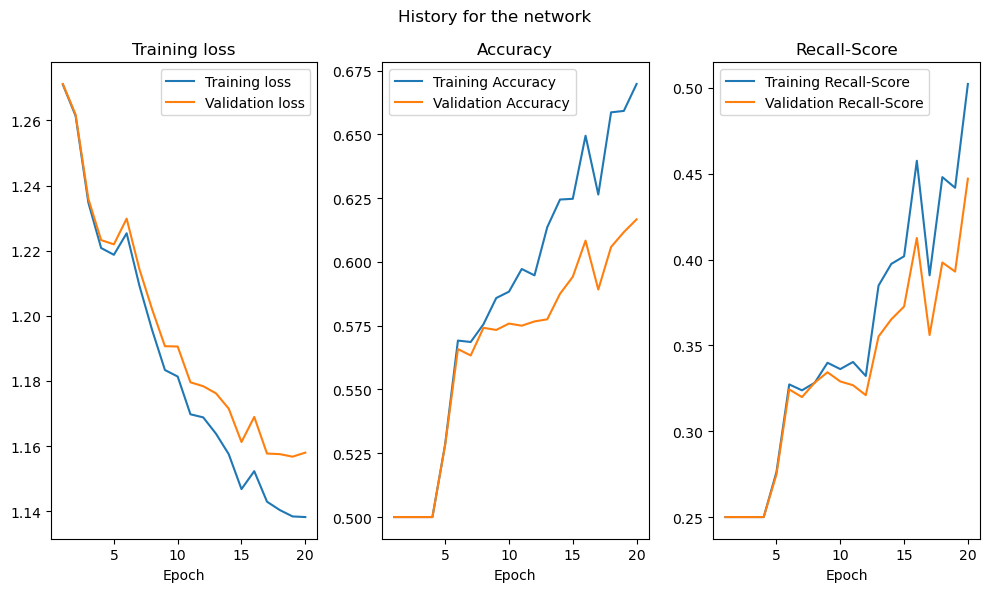

In [15]:
loss_training_hist = dynamic_model.history['loss']
training_acc_hist = dynamic_model.history['acc']
training_w_recall_hist = dynamic_model.history['macro recall']
loss_val_hist = dynamic_model.history_validation['loss']
val_acc_hist = dynamic_model.history_validation['acc']
val_w_recall_hist = dynamic_model.history_validation['macro recall']

x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
fig, ax = plt.subplots(1, 3, figsize=(10,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

ax[2].plot(x_epochs, training_w_recall_hist, label='Training Recall-Score')
ax[2].plot(x_epochs, val_w_recall_hist, label='Validation Recall-Score')
ax[2].set(
    xlabel='Epoch',
    title = 'Recall-Score',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report
y_pred, y_true = dynamic_model.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       800
           1       0.49      0.59      0.54       560
           2       0.68      0.22      0.34       224
           3       0.00      0.00      0.00        16

    accuracy                           0.62      1600
   macro avg       0.47      0.40      0.40      1600
weighted avg       0.63      0.62      0.61      1600



/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Hyperparameter search

In [ ]:
from itertools import product
params_to_test = ({
    'num_dense_layers' : [2, 4],
    'num_dense_nodes' : [512, 2048, 8192],
    'factor' : [2, 3],
})

value_combis = product(*[v for v in params_to_test.values()])

hyperparameter_combinations = []
for combi in value_combis:
  hyperparameter_combinations.append({key: value for key, value in zip(params_to_test.keys(), combi)})

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)

# Hyperparameters, which are not tested
epochs = 3
dropout_rate = 0.15
        
# Define lists to store the histories and the corresponding parameters in
hist_loss_params = {}

# Define the metrics to monitor during training and save them in a dict
criterion = nn.CrossEntropyLoss()

def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))

def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)

def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')

metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

smallest_loss = np.inf

# Print the generated combinations
for i, params in enumerate(hyperparameter_combinations):
    # Define model
    test_model = Custom_DNN(128**2, params['num_dense_nodes'], num_classes, params['num_dense_layers'], ('/', params['factor']), dropout_rate=dropout_rate, evaluation_metrics=metrics)
    # Setup
    early_stopper = EarlyStopper(test_model, patience=7, min_delta=0.005)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    functions.train_network(test_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)
    # Get history
    loss_training_hist, acc_training_hist, macro_recall_training_hist = test_model.history['loss'], test_model.history['acc'], test_model.history['macro recall']
    loss_validation_hist, acc_validation_hist, macro_recall_validation_hist = test_model.history['loss'], test_model.history_validation['acc'], test_model.history_validation['macro recall']
    # Store the hists etc
    hist_loss_params[tuple(params.items())] = (loss_training_hist, acc_training_hist, macro_recall_training_hist, loss_validation_hist, acc_validation_hist, macro_recall_validation_hist)

    if loss_validation_hist[-1] < smallest_loss:
        torch.save(test_model, 'best_dnn.pth')
        smallest_loss = loss_validation_hist[-1]

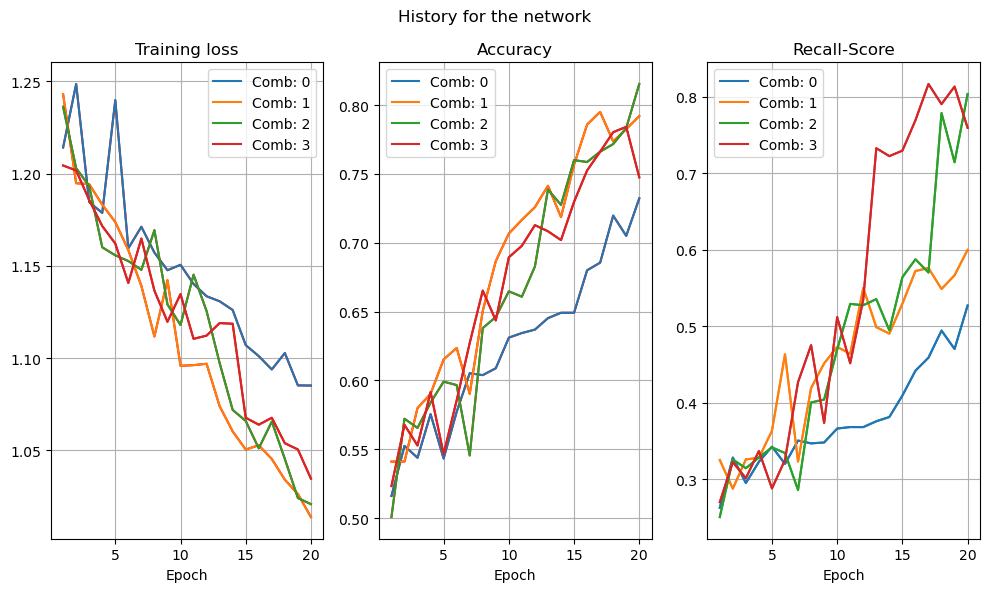

In [ ]:
from itertools import cycle

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(10,6))
ax[0].set(
    xlabel='Epoch',
    title='Training loss',
)
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)
ax[2].set(
    xlabel='Epoch',
    title = 'Recall-Score',
)

color_cycle = plt.cm.tab10(np.arange(len(hyperparameter_combinations)))
# Create a cycle iterator for colors
color_iter = cycle(color_cycle)

for i, params in enumerate(hyperparameter_combinations):
    color = next(color_iter)
    (loss_training_hist, acc_training_hist, macro_recall_training_hist, loss_validation_hist, acc_validation_hist, macro_recall_validation_hist) = hist_loss_params[tuple(params.items())]
    x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
    # Loss
    ax[0].plot(x_epochs, loss_training_hist, c = 'r')
    ax[0].plot(x_epochs, loss_validation_hist, label = f'Comb: {i}', c = color)
    # Acc
    ax[1].plot(x_epochs, acc_training_hist, c = 'r')
    ax[1].plot(x_epochs, acc_validation_hist, label = f'Comb: {i}', c = color)
    # Acc
    ax[2].plot(x_epochs, macro_recall_training_hist)
    ax[2].plot(x_epochs, macro_recall_validation_hist, label = f'Comb: {i}', c = color)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
ax[0].grid(':')
ax[1].grid(':')
ax[2].grid(':')
plt.tight_layout()
plt.show() 